#Get data

In [1]:
from zipfile import ZipFile

with ZipFile("/kaggle/input/hbku2019/imgs.zip", 'r') as z:
    z.extractall()
with ZipFile("/kaggle/input/hbku2019/labels.zip", 'r') as z:
    z.extractall()

In [2]:
!pip install iterative-stratification

#Dataset and Dataloader

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models

In [4]:
from torchmetrics.classification import MultilabelAccuracy, MultilabelF1Score

In [6]:
import numpy as np
import pandas as pd

classes = pd.read_csv('labels/categories.csv', header=None)
classes = list(classes[0])
classes, len(classes)

(['person',
  'bicycle',
  'car',
  'motorcycle',
  'airplane',
  'bus',
  'train',
  'truck',
  'boat',
  'traffic light',
  'fire hydrant',
  'stop sign',
  'parking meter',
  'bench',
  'bird',
  'cat',
  'dog',
  'horse',
  'sheep',
  'cow',
  'elephant',
  'bear',
  'zebra',
  'giraffe',
  'backpack',
  'umbrella',
  'handbag',
  'tie',
  'suitcase',
  'frisbee',
  'skis',
  'snowboard',
  'sports ball',
  'kite',
  'baseball bat',
  'baseball glove',
  'skateboard',
  'surfboard',
  'tennis racket',
  'bottle',
  'wine glass',
  'cup',
  'fork',
  'knife',
  'spoon',
  'bowl',
  'banana',
  'apple',
  'sandwich',
  'orange',
  'broccoli',
  'carrot',
  'hot dog',
  'pizza',
  'donut',
  'cake',
  'chair',
  'couch',
  'potted plant',
  'bed',
  'dining table',
  'toilet',
  'tv',
  'laptop',
  'mouse',
  'remote',
  'keyboard',
  'cell phone',
  'microwave',
  'oven',
  'toaster',
  'sink',
  'refrigerator',
  'book',
  'clock',
  'vase',
  'scissors',
  'teddy bear',
  'hair dri

In [14]:
data = pd.read_csv('labels/labels_train.csv', header=None)
x = data.iloc[:, 0]
y = data.iloc[:, 1:]

In [8]:
from PIL import Image

class MultilabelDataset(Dataset):
    def __init__(self, data, transform, idx):
        self.transform = transform
        self.data = data.loc[idx]
        self.imgpaths = np.asarray(self.data.iloc[:, 0])
        self.labelsarr = np.asarray(self.data.iloc[:, 1:]).astype(np.float32)

    def __getitem__(self, index):
      
        img = Image.open("imgs/train/" + self.imgpaths[index]).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        labels = self.labelsarr[index]

        return (img, labels)

    def __len__(self):
        return len(self.imgpaths)

In [9]:
gpu = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#Model creation

In [11]:
def create_resnext():
    model = models.resnext50_32x4d(pretrained=True)
  
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    for param in model.parameters():
        param.requires_grad = False

    model.fc = nn.Sequential(
      nn.Linear(in_features=2048, out_features=len(classes), bias=True)
  )

    return model

#Training and Testing

In [18]:
#Training and testing loop will call sigmoid as func is not there in the networks

from tqdm.auto import tqdm

accfn = MultilabelAccuracy(num_labels=len(classes))
f1fn = MultilabelF1Score(num_labels=len(classes))

def trainloop(model, trainloader, lossfn, optim):
    totalloss, totalacc, totalf1 = 0, 0, 0
    n = len(trainloader)

    model.train()
    for x, y in tqdm(trainloader):
        ylogit = model(x.to(gpu))
        yprob = torch.sigmoid(ylogit)
        ypred = np.around(yprob.detach().cpu())
    
        loss = lossfn(yprob, y.to(gpu))
        optim.zero_grad()
        loss.backward()
        optim.step()

        totalloss += loss.item()
        totalacc += accfn(ypred, y).item()
        totalf1 += f1fn(ypred, y).item()
    
    torch.save(model.state_dict(), 'resnext.pth')
    return totalloss/n, totalacc/n, totalf1/n

def testloop(model, testloader, lossfn):
    totalloss, totalacc, totalf1 = 0, 0, 0
    n = len(testloader)

    model.eval()
    with torch.inference_mode():
        for x, y in tqdm(testloader):
            ylogit = model(x.to(gpu))
            yprob = torch.sigmoid(ylogit)
            ypred = np.around(yprob.detach().cpu())

            loss = lossfn(yprob, y.to(gpu))

            totalloss += loss.item()
            totalacc += accfn(ypred, y).item()
            totalf1 += f1fn(ypred, y).item()

    return totalloss/n, totalacc/n, totalf1/n

In [20]:
import os
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = create_resnext()
if torch.cuda.device_count() > 1:
    print("We will use", 2, "GPUs")
    model = nn.DataParallel(model)
model.to(gpu)

lossfn = nn.BCELoss()
optim = torch.optim.Adam(params=model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.3)

batchsize = 64

mskf = MultilabelStratifiedKFold(n_splits=5)

for fold, (trainidx, validx) in enumerate(mskf.split(x, y)):
    traindata = MultilabelDataset(data, transform, trainidx)
    valdata = MultilabelDataset(data, transform, validx)
    trainloader = DataLoader(traindata, batch_size=batchsize, shuffle=True)
    valloader = DataLoader(valdata, batch_size=batchsize)
    
    trainloss, trainacc, trainf1 = trainloop(model, trainloader, lossfn, optim)
    valloss, valacc, valf1 = testloop(model, valloader, lossfn)
    scheduler.step()
    
    print("Fold:", fold+1, "Train loss:", trainloss, "Train acc:", trainacc, "Train f1:", trainf1,\
          "Val loss:", valloss, "Val acc:", valacc, "Val f1:", valf1)

    print('-'*50 + '\n')

We will use 2 GPUs


  0%|          | 0/1223 [00:00<?, ?it/s]

  0%|          | 0/306 [00:00<?, ?it/s]

Fold: 1 Train loss: 0.19081263610284444 Train acc: 0.9710604455855082 Train f1: 0.3089496099766274 Val loss: 0.1551517181652385 Val acc: 0.9691783721540489 Val f1: 0.1362091032909899
--------------------------------------------------



  0%|          | 0/1222 [00:00<?, ?it/s]

  0%|          | 0/307 [00:00<?, ?it/s]

Fold: 2 Train loss: 0.11424188722235969 Train acc: 0.9760320263193789 Train f1: 0.3852112593461566 Val loss: 0.10806219949893629 Val acc: 0.9761056546667888 Val f1: 0.14612319684475175
--------------------------------------------------



  0%|          | 0/1223 [00:00<?, ?it/s]

  0%|          | 0/306 [00:00<?, ?it/s]

Fold: 3 Train loss: 0.09719778343316286 Train acc: 0.9778772172923957 Train f1: 0.40282356837430844 Val loss: 0.09302225230212986 Val acc: 0.9785733482027366 Val f1: 0.15847565198098035
--------------------------------------------------



  0%|          | 0/1223 [00:00<?, ?it/s]

  0%|          | 0/305 [00:00<?, ?it/s]

Fold: 4 Train loss: 0.08570746730218047 Train acc: 0.9785682121360292 Train f1: 0.41064837511601454 Val loss: 0.07739857461944712 Val acc: 0.9793944184897376 Val f1: 0.167887753941363
--------------------------------------------------



  0%|          | 0/1223 [00:00<?, ?it/s]

  0%|          | 0/306 [00:00<?, ?it/s]

Fold: 5 Train loss: 0.07911752394338854 Train acc: 0.9788524288674991 Train f1: 0.4143717970153833 Val loss: 0.0761606833574916 Val acc: 0.9797799624259176 Val f1: 0.166910394505762
--------------------------------------------------



#Test set human evaluation

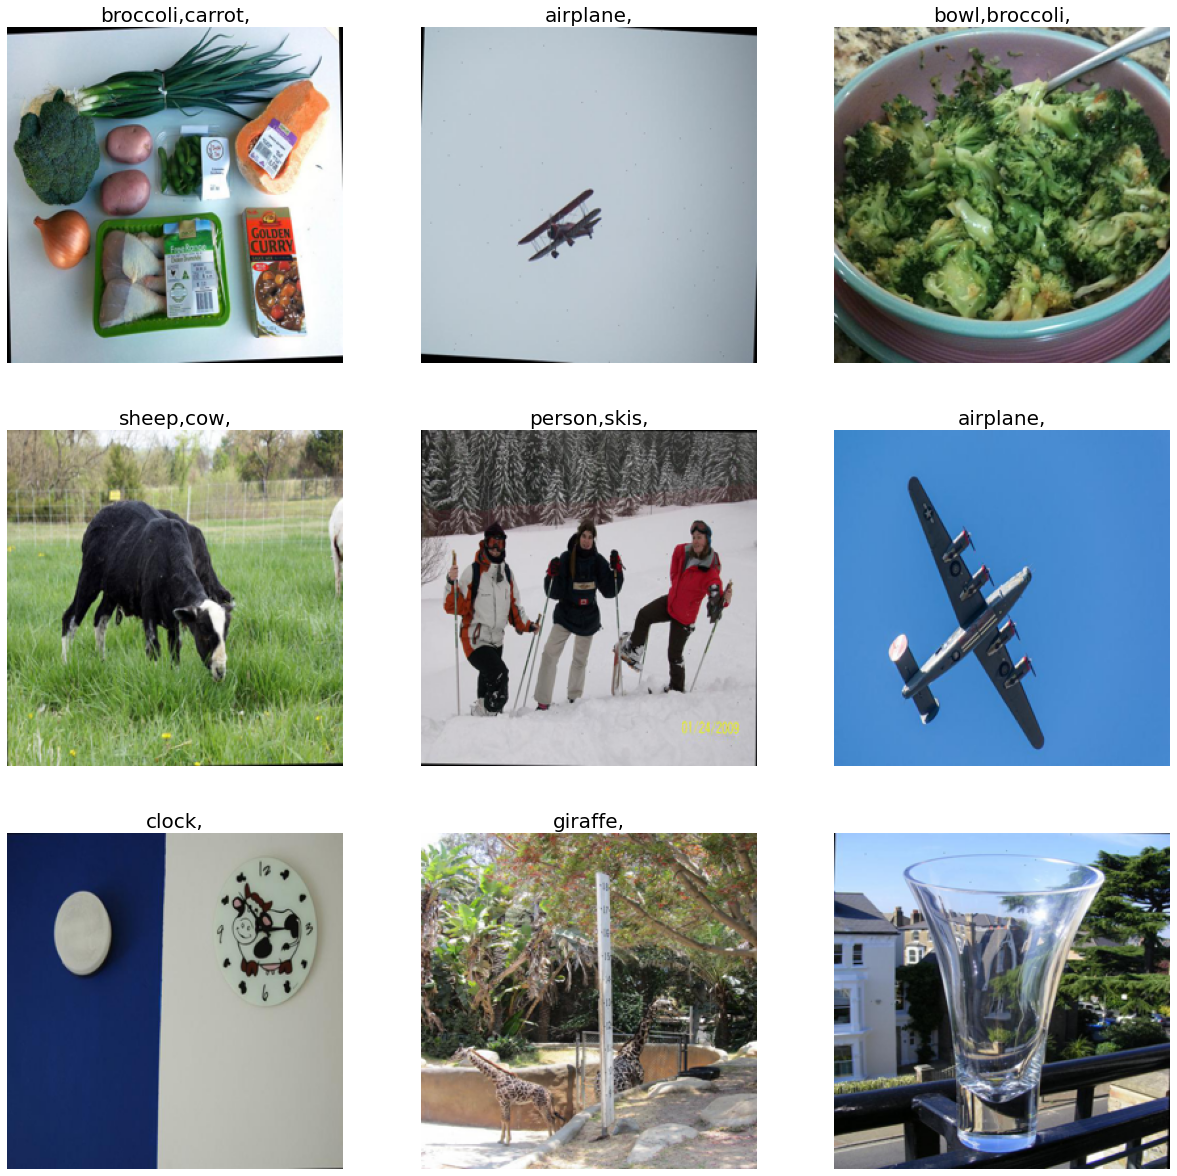

In [21]:
import random
from matplotlib import pyplot as plt

imgs = random.sample(os.listdir('imgs/test/'), 9)

model = create_resnext()
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model.to(gpu)
model.load_state_dict(torch.load('resnext.pth'))

plt.figure(figsize=(21, 21))

for i in range(9):
  img = Image.open('imgs/test/' + imgs[i]).convert('RGB')
  newimg = transform(img).unsqueeze(dim=0)

  model.eval()
  with torch.inference_mode():
    yprob = model(newimg.to(gpu)).cpu()

  indices = np.where(yprob.squeeze(dim=0) > 0.5)

  plt.subplot(3, 3, i+1)
  plt.imshow(img.resize((256, 256)))
  plt.axis(False)
  
  objects = ''
  space = 0
  for idx in indices[0]:
    objects += classes[idx] + ','
    space += 1
    if space % 4 == 0:
      objects += '\n'
  
  plt.title(objects.rstrip(), fontsize=20)

#Test csv for submission

In [22]:
class CustomTestDataset(Dataset):
  def __init__(self, path, transform):
    self.transform = transform
    self.path = path
    self.paths = sorted(os.listdir(path))
    self.image_arr = np.asarray(self.paths)
    self.data_len = len(self.image_arr)

  def __getitem__(self, index):
    single_image_name = self.image_arr[index]
    img = Image.open(self.path + single_image_name).convert('RGB')

    if self.transform is not None:
      img = self.transform(img)

    return (img, single_image_name)

  def __len__(self):
    return self.data_len

In [23]:
testdata = CustomTestDataset('imgs/test/', transform)
testloader = DataLoader(testdata, batch_size=1, shuffle=False)

In [24]:
predictions = None

model.eval()
with torch.inference_mode():
  for x, _ in tqdm(testloader):
    yprob = model(x.to(gpu)).detach().cpu()
    outputs = np.around(yprob)
    try:
      predictions = np.concatenate((predictions,outputs))
    except:
      predictions = outputs

  0%|          | 0/24444 [00:00<?, ?it/s]

In [25]:
outputs = []
for x in predictions:
    a = np.nonzero(x)[0]
    b = " ".join(map(str, a))
    outputs.append(b)

In [26]:
submission = pd.DataFrame({'id':testdata.paths, 'predictions':outputs})
submission.to_csv('resnext2_submission.csv', index=False)